# Image generation with Stable Diffusion v3 and OpenVINO

Stable Diffusion V3 is next generation of latent diffusion image Stable Diffusion models family that  outperforms state-of-the-art text-to-image generation systems in typography and prompt adherence, based on human preference evaluations. In comparison with previous versions, it based on Multimodal Diffusion Transformer (MMDiT) text-to-image model that features greatly improved performance in image quality, typography, complex prompt understanding, and resource-efficiency.

![mmdit.png](https://github.com/openvinotoolkit/openvino_notebooks/assets/29454499/dd079427-89f2-4d28-a10e-c80792d750bf)

More details about model can be found in [model card](https://huggingface.co/stabilityai/stable-diffusion-3-medium), [research paper](https://stability.ai/news/stable-diffusion-3-research-paper) and [Stability.AI blog post](https://stability.ai/news/stable-diffusion-3-medium).
In this tutorial, we will consider how to convert Stable Diffusion v3 for running with OpenVINO. An additional part demonstrates how to run optimization with [NNCF](https://github.com/openvinotoolkit/nncf/) to speed up pipeline.
If you want to run previous Stable Diffusion versions, please check our other notebooks:

* [Stable Diffusion](../stable-diffusion-text-to-image)
* [Stable Diffusion v2](../stable-diffusion-v2)
* [Stable Diffusion XL](../stable-diffusion-xl)
* [LCM Stable Diffusion](../latent-consistency-models-image-generation)
* [Turbo SDXL](../sdxl-turbo)
* [Turbo SD](../sketch-to-image-pix2pix-turbo)

#### Table of contents:

- [Prerequisites](#Prerequisites)
- [Build PyTorch pipeline](#Build-PyTorch-pipeline)
- [Convert models with OpenVINO](#Convert-models-with-OpenVINO)
    - [Transformer](#Transformer)
    - [T5 Text Encoder](#T5-Text-Encoder)
    - [Clip text encoders](#Clip-text-encoders)
    - [VAE](#VAE)
- [Prepare OpenVINO inference pipeline](#Prepare-OpenVINO-inference-pipeline)
- [Run OpenVINO model](#Run-OpenVINO-model)
- [Quantization](#Quantization)
    - [Prepare calibration dataset](#Prepare-calibration-dataset)
    - [Run Quantization](#Run-Quantization)
    - [Run Weights Compression](#Run-Weights-Compression)
    - [Compare model file sizes](#Compare-model-file-sizes)
    - [Compare inference time of the FP16 and optimized pipelines](#Compare-inference-time-of-the-FP16-and-optimized-pipelines)
- [Interactive demo](#Interactive-demo)


### Installation Instructions

This is a self-contained example that relies solely on its own code.

We recommend  running the notebook in a virtual environment. You only need a Jupyter server to start.
For details, please refer to [Installation Guide](https://github.com/openvinotoolkit/openvino_notebooks/blob/latest/README.md#-installation-guide).

<img referrerpolicy="no-referrer-when-downgrade" src="https://static.scarf.sh/a.png?x-pxid=5b5a4db0-7875-4bfb-bdbd-01698b5b1a77&file=notebooks/stable-diffusion-v3/stable-diffusion-v3.ipynb" />


## Prerequisites
[back to top ⬆️](#Table-of-contents:)

In [1]:
%pip install -q "git+https://github.com/initml/diffusers.git@clement/feature/flash_sd3" "gradio>=4.19" "torch>=2.1"  "transformers" "nncf>=2.12.0" "datasets>=2.14.6" "opencv-python" "pillow" "peft>=0.7.0" --extra-index-url https://download.pytorch.org/whl/cpu
%pip install -qU "openvino>=2024.3.0"

    numpy (>=1.19.*) ; python_version >= "3.7"
           ~~~~~~~^
Note: you may need to restart the kernel to use updated packages.
    numpy (>=1.19.*) ; python_version >= "3.7"
           ~~~~~~~^
Note: you may need to restart the kernel to use updated packages.


In [2]:
import requests
from pathlib import Path

if not Path("sd3_helper.py").exists():
    r = requests.get(url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/notebooks/stable-diffusion-v3/sd3_helper.py")
    open("sd3_helper.py", "w").write(r.text)

if not Path("sd3_quantization_helper.py").exists():
    r = requests.get(url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/notebooks/stable-diffusion-v3/sd3_quantization_helper.py")
    open("sd3_quantization_helper.py", "w").write(r.text)

if not Path("gradio_helper.py").exists():
    r = requests.get(url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/notebooks/stable-diffusion-v3/gradio_helper.py")
    open("gradio_helper.py", "w").write(r.text)

if not Path("notebook_utils.py").exists():
    r = requests.get(url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/utils/notebook_utils.py")
    open("notebook_utils.py", "w").write(r.text)

## Build PyTorch pipeline
[back to top ⬆️](#Table-of-contents:)

>**Note**: run model with notebook, you will need to accept license agreement. 
>You must be a registered user in 🤗 Hugging Face Hub. Please visit [HuggingFace model card](https://huggingface.co/stabilityai/stable-diffusion-3-medium-diffusers), carefully read terms of usage and click accept button.  You will need to use an access token for the code below to run. For more information on access tokens, refer to [this section of the documentation](https://huggingface.co/docs/hub/security-tokens).
>You can login on Hugging Face Hub in notebook environment, using following code:

In [3]:
# uncomment these lines to login to huggingfacehub to get access to pretrained model

# from huggingface_hub import notebook_login, whoami

# try:
#     whoami()
#     print('Authorization token already provided')
# except OSError:
#     notebook_login()

We will use [Diffusers](https://huggingface.co/docs/diffusers/main/en/index) library integration for running Stable Diffusion v3 model. You can find more details in Diffusers [documentation](https://huggingface.co/docs/diffusers/main/en/api/pipelines/stable_diffusion/stable_diffusion_3).
Additionally, we can apply optimization for pipeline performance and memory consumption:

* **Use flash SD3**. Flash Diffusion is a diffusion distillation method proposed in [Flash Diffusion: Accelerating Any Conditional Diffusion Model for Few Steps Image Generation](http://arxiv.org/abs/2406.02347). The model represented as a 90.4M LoRA distilled version of SD3 model that is able to generate 1024x1024 images in 4 steps. If you want disable it, you can unset checkbox **Use flash SD3**
* **Remove T5 text encoder**. Removing the memory-intensive 4.7B parameter T5-XXL text encoder during inference can significantly decrease the memory requirements for SD3 with only a slight loss in performance. If you want to use this model in pipeline, please set **use t5 text encoder** checkbox.

In [4]:
from sd3_helper import get_pipeline_options

pt_pipeline_options, use_flash_lora, load_t5 = get_pipeline_options()

display(pt_pipeline_options)

/home/ea/work/my_optimum_intel/optimum_env/lib/python3.8/site-packages/diffusers/models/transformers/transformer_2d.py:34: FutureWarning: `Transformer2DModelOutput` is deprecated and will be removed in version 1.0.0. Importing `Transformer2DModelOutput` from `diffusers.models.transformer_2d` is deprecated and this will be removed in a future version. Please use `from diffusers.models.modeling_outputs import Transformer2DModelOutput`, instead.
  deprecate("Transformer2DModelOutput", "1.0.0", deprecation_message)
2024-08-07 18:03:27.376432: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-07 18:03:27.378435: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-07 18:03:27.415396: I tensorflow/core/platfor

## Convert models with OpenVINO
[back to top ⬆️](#Table-of-contents:)

Starting from 2023.0 release, OpenVINO supports PyTorch models directly via Model Conversion API. `ov.convert_model` function accepts instance of PyTorch model and example inputs for tracing and returns object of `ov.Model` class, ready to use or save on disk using `ov.save_model` function. 


The pipeline consists of four important parts:

* Clip and T5 Text Encoders to create condition to generate an image from a text prompt.
* Transformer for step-by-step denoising latent image representation.
* Autoencoder (VAE) for decoding latent space to image.

We will use `convert_sd3` helper function defained in [sd3_helper.py](./sd3_helper.py) that create original PyTorch model and convert each part of pipeline using `ov.convert_model`.

In [5]:
from sd3_helper import convert_sd3

# Uncomment the line beolow to see model conversion code
# ??convert_sd3

In [6]:
convert_sd3(load_t5.value, use_flash_lora.value)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Transformer model conversion started


[ WARNING ]  Please fix your imports. Module %s has been moved to %s. The old module will be deleted in version %s.
/home/ea/work/my_optimum_intel/optimum_env/lib/python3.8/site-packages/diffusers/models/embeddings.py:186: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if height > self.pos_embed_max_size:
/home/ea/work/my_optimum_intel/optimum_env/lib/python3.8/site-packages/diffusers/models/embeddings.py:190: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if width > self.pos_embed_max_size:


Transformer model conversion finished
Clip Text encoder 1 conversion started


/home/ea/work/my_optimum_intel/optimum_env/lib/python3.8/site-packages/transformers/modeling_utils.py:4664: FutureWarning: `_is_quantized_training_enabled` is going to be deprecated in transformers 4.39.0. Please use `model.hf_quantizer.is_trainable` instead
  warnings.warn(
/home/ea/work/my_optimum_intel/optimum_env/lib/python3.8/site-packages/transformers/modeling_attn_mask_utils.py:86: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if input_shape[-1] > 1 or self.sliding_window is not None:
/home/ea/work/my_optimum_intel/optimum_env/lib/python3.8/site-packages/transformers/modeling_attn_mask_utils.py:162: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be t

Clip Text encoder 1 conversion finished
Clip Text encoder 2 conversion started
Clip Text encoder 2 conversion finished
VAE decoder conversion started


/home/ea/work/my_optimum_intel/optimum_env/lib/python3.8/site-packages/diffusers/models/upsampling.py:146: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  assert hidden_states.shape[1] == self.channels
/home/ea/work/my_optimum_intel/optimum_env/lib/python3.8/site-packages/diffusers/models/upsampling.py:162: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if hidden_states.shape[0] >= 64:


## Prepare OpenVINO inference pipeline
[back to top ⬆️](#Table-of-contents:)

In [7]:
from sd3_helper import OVStableDiffusion3Pipeline, init_pipeline # noqa: F401

# Uncomment line below to see pipeline code
# ??OVStableDiffusion3Pipeline

## Run OpenVINO model
[back to top ⬆️](#Table-of-contents:)

In [8]:
from notebook_utils import device_widget

device = device_widget()

device

Dropdown(description='Device:', index=1, options=('CPU', 'AUTO'), value='AUTO')

In [9]:
from sd3_helper import TEXT_ENCODER_PATH, TEXT_ENCODER_2_PATH, TEXT_ENCODER_3_PATH, TRANSFORMER_PATH, VAE_DECODER_PATH

models_dict = {"transformer": TRANSFORMER_PATH, "vae": VAE_DECODER_PATH, "text_encoder": TEXT_ENCODER_PATH, "text_encoder_2": TEXT_ENCODER_2_PATH}

if load_t5.value:
    models_dict["text_encoder_3"] = TEXT_ENCODER_3_PATH

ov_pipe = init_pipeline(models_dict, device.value, use_flash_lora.value)

Models compilation
transformer - Done!
vae - Done!
text_encoder - Done!
text_encoder_2 - Done!


  0%|          | 0/4 [00:00<?, ?it/s]

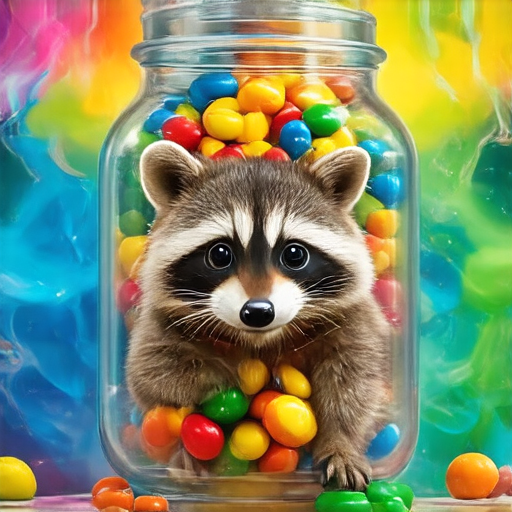

In [10]:
import torch

image = ov_pipe(
    "A raccoon trapped inside a glass jar full of colorful candies, the background is steamy with vivid colors",
    negative_prompt="",
    num_inference_steps=28 if not use_flash_lora.value else 4,
    guidance_scale=5 if not use_flash_lora.value else 0,
    height=512,
    width=512,
    generator=torch.Generator().manual_seed(141),
).images[0]
image

## Quantization
[back to top ⬆️](#Table-of-contents:)

[NNCF](https://github.com/openvinotoolkit/nncf/) enables post-training quantization by adding quantization layers into model graph and then using a subset of the training dataset to initialize the parameters of these additional quantization layers. Quantized operations are executed in `INT8` instead of `FP32`/`FP16` making model inference faster.

According to `OVStableDiffusion3Pipeline` structure, the `transformer` model takes up significant portion of the overall pipeline execution time. Now we will show you how to optimize the UNet part using [NNCF](https://github.com/openvinotoolkit/nncf/) to reduce computation cost and speed up the pipeline. Quantizing the rest of the pipeline does not significantly improve inference performance but can lead to a substantial degradation of accuracy. That's why we use 4-bit weight compression for the rest of the pipeline to reduce memory footprint.

Please select below whether you would like to run quantization to improve model inference speed.

> **NOTE**: Quantization is time and memory consuming operation. Running quantization code below may take some time.

In [11]:
from notebook_utils import quantization_widget
from sd3_quantization_helper import (
    TRANSFORMER_INT8_PATH, 
    TEXT_ENCODER_INT4_PATH, 
    TEXT_ENCODER_2_INT4_PATH, 
    TEXT_ENCODER_3_INT4_PATH, 
    VAE_DECODER_INT4_PATH
)

to_quantize = quantization_widget()

to_quantize

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


INFO:nncf:NNCF initialized successfully. Supported frameworks detected: torch, tensorflow, onnx, openvino


Checkbox(value=True, description='Quantization')

Let's load `skip magic` extension to skip quantization if `to_quantize` is not selected

In [12]:
# Fetch `skip_kernel_extension` module
import requests

r = requests.get(
    url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/utils/skip_kernel_extension.py",
)
open("skip_kernel_extension.py", "w").write(r.text)

optimized_pipe = None

opt_models_dict = {"transformer": TRANSFORMER_INT8_PATH, "text_encoder": TEXT_ENCODER_INT4_PATH, "text_encoder_2": TEXT_ENCODER_2_INT4_PATH, "vae": VAE_DECODER_INT4_PATH}

if TEXT_ENCODER_3_PATH.exists():
    opt_models_dict["text_encoder_3"] = TEXT_ENCODER_3_INT4_PATH

%load_ext skip_kernel_extension

### Prepare calibration dataset
[back to top ⬆️](#Table-of-contents:)

We use a portion of [`google-research-datasets/conceptual_captions`](https://huggingface.co/datasets/google-research-datasets/conceptual_captions) dataset from Hugging Face as calibration data. We use prompts below to guide image generation and to determine what not to include in the resulting image.

To collect intermediate model inputs for calibration we should customize `CompiledModel`. We should set the height and width of the image to 512 to reduce memory consumption during quantization.

In [13]:
%%skip not $to_quantize.value

from sd3_quantization_helper import collect_calibration_data, TRANSFORMER_INT8_PATH

# Uncomment the line to see calibration data collection code
# ??collect_calibration_data


### Run Quantization
[back to top ⬆️](#Table-of-contents:)

Quantization of the first `Convolution` layer impacts the generation results. We recommend using `IgnoredScope` to keep accuracy sensitive layers in FP16 precision.

In [14]:
%%skip not $to_quantize.value

import nncf
import gc
import openvino as ov

core = ov.Core()


if not TRANSFORMER_INT8_PATH.exists():
    calibration_dataset_size = 200
    print("Calibration data collection started")
    unet_calibration_data = collect_calibration_data(ov_pipe,
                                                     calibration_dataset_size=calibration_dataset_size,
                                                     num_inference_steps=28 if not use_flash_lora.value else 4,
                                                     guidance_scale=5 if not use_flash_lora.value else 0
                                                     )
    print("Calibration data collection finished")
    
    del ov_pipe
    gc.collect()
    ov_pipe = None

    transformer = core.read_model(TRANSFORMER_PATH)
    quantized_model = nncf.quantize(
        model=transformer,
        calibration_dataset=nncf.Dataset(unet_calibration_data),
        subset_size=calibration_dataset_size,
        model_type=nncf.ModelType.TRANSFORMER,
        ignored_scope=nncf.IgnoredScope(names=["__module.model.base_model.model.pos_embed.proj.base_layer/aten::_convolution/Convolution"]),
    )

    ov.save_model(quantized_model, TRANSFORMER_INT8_PATH)

Calibration data collection started


  0%|          | 0/200 [00:00<?, ?it/s]

Calibration data collection finished


Output()

Output()

INFO:nncf:1 ignored nodes were found by names in the NNCFGraph
INFO:nncf:Not adding activation input quantizer for operation: 4 __module.model.base_model.model.pos_embed.proj.base_layer/aten::_convolution/Convolution
10 __module.model.base_model.model.pos_embed.proj.base_layer/aten::_convolution/Add



Output()

Output()

### Run Weights Compression
[back to top ⬆️](#Table-of-contents:)

Quantizing of the `Text Encoders` and `Autoencoder` does not significantly improve inference performance but can lead to a substantial degradation of accuracy.

For reducing model memory consumption we will use weights compression. The [Weights Compression](https://docs.openvino.ai/2024/openvino-workflow/model-optimization-guide/weight-compression.html) algorithm is aimed at compressing the weights of the models and can be used to optimize the model footprint and performance of large models where the size of weights is relatively larger than the size of activations, for example, Large Language Models (LLM). Compared to INT8 compression, INT4 compression improves performance even more, but introduces a minor drop in prediction quality.

In [15]:
%%skip not $to_quantize.value

from sd3_quantization_helper import compress_models

compress_models()

Output()

text_encoder compression started
Compression parameters:
	mode = int4_sym
	ratio = 0.8
	group_size = 128


INFO:nncf:Statistics of the bitwidth distribution:
┍━━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┑
│   Num bits (N) │ % all parameters (layers)   │ % ratio-defining parameters (layers)   │
┝━━━━━━━━━━━━━━━━┿━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┿━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┥
│              8 │ 45% (26 / 75)               │ 20% (23 / 72)                          │
├────────────────┼─────────────────────────────┼────────────────────────────────────────┤
│              4 │ 55% (49 / 75)               │ 80% (49 / 72)                          │
┕━━━━━━━━━━━━━━━━┷━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┷━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┙


Output()

text_encoder compression finished
Compressed text_encoder can be found in stable-diffusion-3/text_encoder_int4.xml
text_encoder_2 compression started
Compression parameters:
	mode = int4_sym
	ratio = 0.8
	group_size = 128


Output()

INFO:nncf:Statistics of the bitwidth distribution:
┍━━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┑
│   Num bits (N) │ % all parameters (layers)   │ % ratio-defining parameters (layers)   │
┝━━━━━━━━━━━━━━━━┿━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┿━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┥
│              8 │ 28% (44 / 195)              │ 21% (41 / 192)                         │
├────────────────┼─────────────────────────────┼────────────────────────────────────────┤
│              4 │ 72% (151 / 195)             │ 79% (151 / 192)                        │
┕━━━━━━━━━━━━━━━━┷━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┷━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┙


Output()

Output()

text_encoder_2 compression finished
Compressed text_encoder_2 can be found in stable-diffusion-3/text_encoder_2_int4.xml
vae_decoder compression started
Compression parameters:
	mode = int4_sym
	ratio = 0.8
	group_size = 128


INFO:nncf:Statistics of the bitwidth distribution:
┍━━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┑
│   Num bits (N) │ % all parameters (layers)   │ % ratio-defining parameters (layers)   │
┝━━━━━━━━━━━━━━━━┿━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┿━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┥
│              8 │ 99% (37 / 39)               │ 33% (1 / 3)                            │
├────────────────┼─────────────────────────────┼────────────────────────────────────────┤
│              4 │ 1% (2 / 39)                 │ 67% (2 / 3)                            │
┕━━━━━━━━━━━━━━━━┷━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┷━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┙


Output()

vae_decoder compression finished
Compressed vae_decoder can be found in stable-diffusion-3/vae_decoder_int4.xml


Let's compare the images generated by the original and optimized pipelines.

In [16]:
%%skip not $to_quantize.value
optimized_pipe = init_pipeline(opt_models_dict, device.value, use_flash_lora.value)

Models compilation
transformer - Done!
text_encoder - Done!
text_encoder_2 - Done!
vae - Done!


  0%|          | 0/4 [00:00<?, ?it/s]

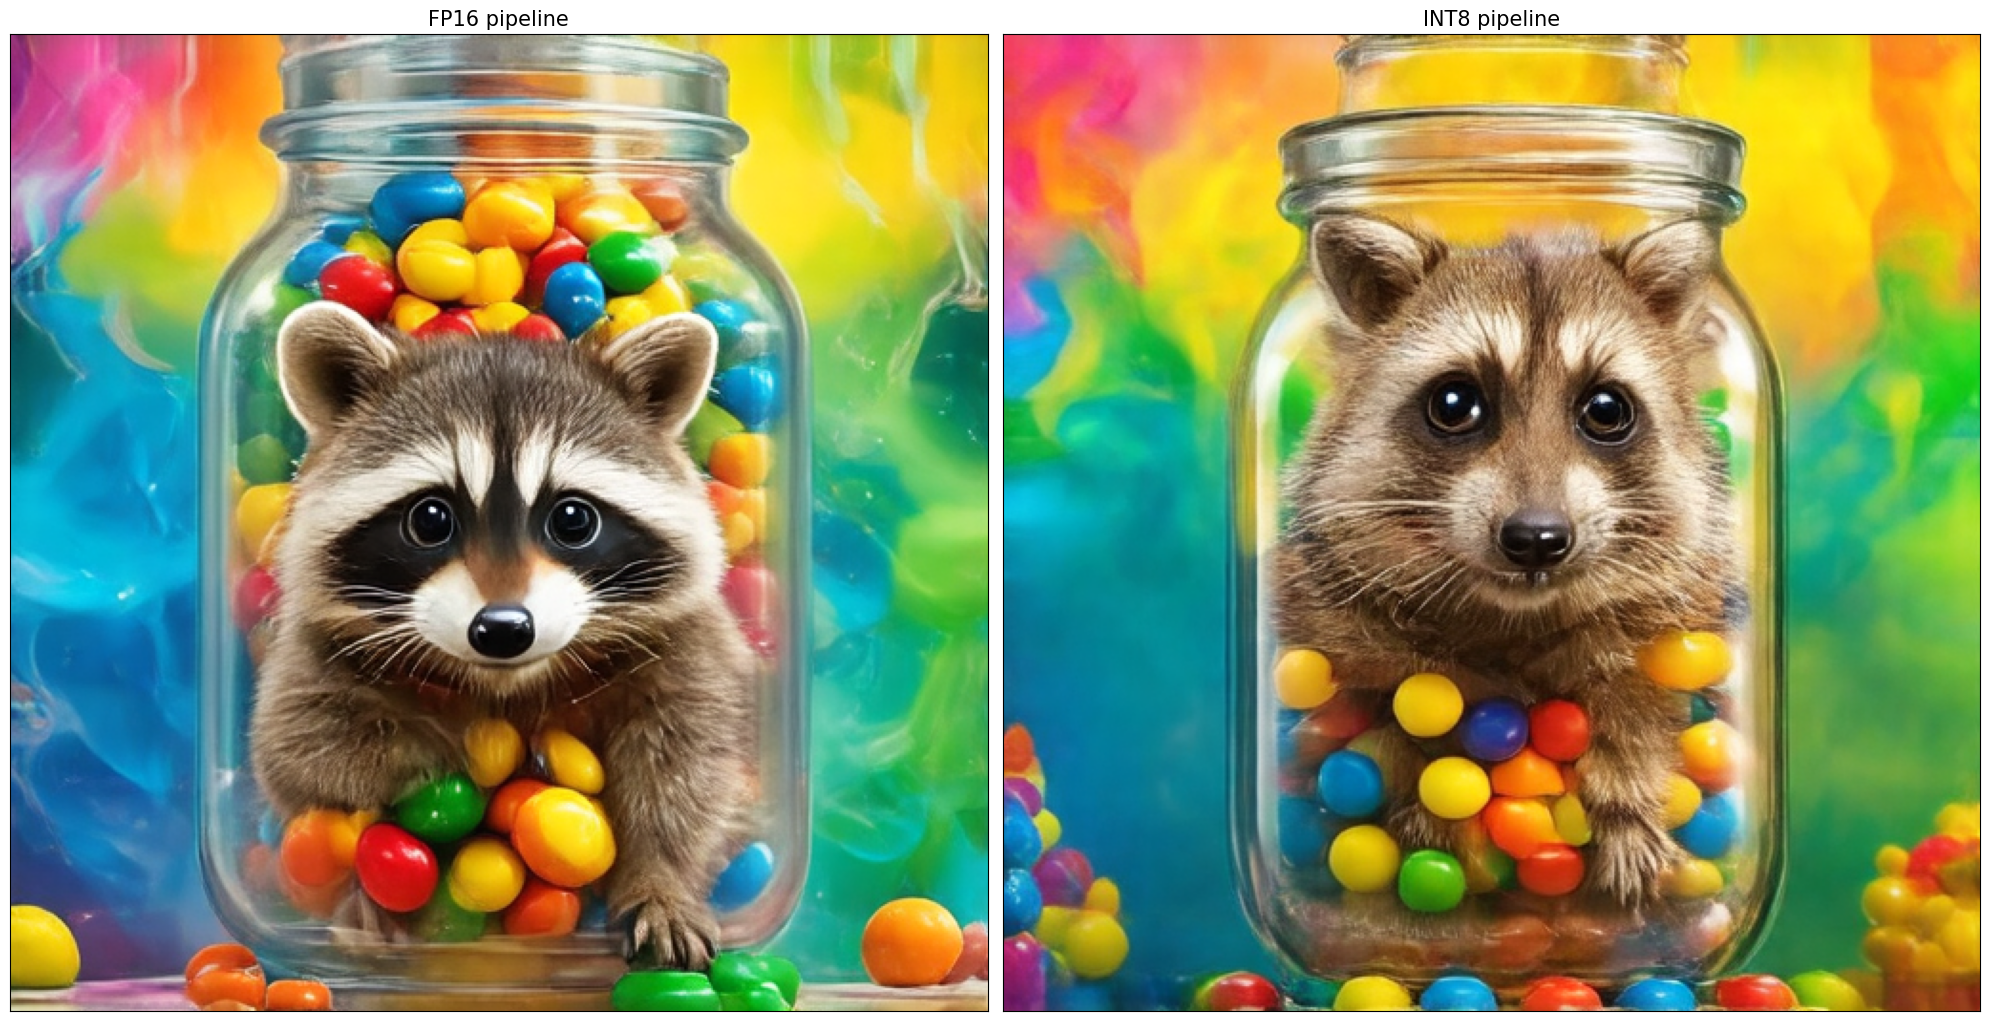

In [17]:
%%skip not $to_quantize.value

from sd3_quantization_helper import visualize_results

opt_image = optimized_pipe(
    "A raccoon trapped inside a glass jar full of colorful candies, the background is steamy with vivid colors",
    negative_prompt="",
    num_inference_steps=28 if not use_flash_lora.value else 4,
    guidance_scale=5 if not use_flash_lora.value else 0,
    height=512,
    width=512,
    generator=torch.Generator().manual_seed(141),
).images[0]

visualize_results(image, opt_image)

### Compare model file sizes
[back to top ⬆️](#Table-of-contents:)

In [18]:
%%skip not $to_quantize.value
from sd3_quantization_helper import compare_models_size

del optimized_pipe
gc.collect()

compare_models_size()

transformer compression rate: 1.939
text_encoder compression rate: 2.714
text_encoder_2 compression rate: 3.057
vae_decoder compression rate: 2.007


### Compare inference time of the FP16 and optimized pipelines
[back to top ⬆️](#Table-of-contents:)

To measure the inference performance of the `FP16` and optimized pipelines, we use mean inference time on 5 samples.

> **NOTE**: For the most accurate performance estimation, it is recommended to run `benchmark_app` in a terminal/command prompt after closing other applications.

In [19]:
%%skip not $to_quantize.value

from sd3_quantization_helper import compare_perf

compare_perf(models_dict, opt_models_dict, device.value, use_flash_lora.value, validation_size=5)

Load FP16 pipeline
Models compilation
transformer - Done!
vae - Done!
text_encoder - Done!
text_encoder_2 - Done!
Load Optimized pipeline
Models compilation
transformer - Done!
text_encoder - Done!
text_encoder_2 - Done!
vae - Done!
Performance speed-up: 1.606


## Interactive demo
[back to top ⬆️](#Table-of-contents:)

Please select below whether you would like to use the quantized models to launch the interactive demo.

In [20]:
from sd3_helper import get_pipeline_selection_option

use_quantized_models = get_pipeline_selection_option(opt_models_dict)

use_quantized_models

Checkbox(value=True, description='Use quantized models')

In [ ]:
from gradio_helper import make_demo

ov_pipe = init_pipeline(model_dict if not use_quantized_models.value else opt_models_dict, device.value, use_flash_lora.value)
demo = make_demo(ov_pipe, use_flash_lora.value)

# if you are launching remotely, specify server_name and server_port
#  demo.launch(server_name='your server name', server_port='server port in int')
# if you have any issue to launch on your platform, you can pass share=True to launch method:
# demo.launch(share=True)
# it creates a publicly shareable link for the interface. Read more in the docs: https://gradio.app/docs/
try:
    demo.launch(debug=True)
except Exception:
    demo.launch(debug=True, share=True)